In [1]:
using CSV
using DataFrames
using JLD2
using Random

include("scripts/data_structures.jl");
include("scripts/data_sampling_helpers.jl")
include("scripts/plotting.jl");

In [2]:
using DataFrames

"One tidy DataFrame with one row per percept, including object- and cluster-level info."
function category_df(cat::CategorySample)
    rows = NamedTuple[]
    for obj in cat.objects
        mu = cat.mus[obj.z]  # cluster mean for this object
        for y in obj.percepts
            push!(rows, (
                percept_x1 = round(y[1], digits=3),
                percept_x2 = round(y[2], digits=3),
                object_id = obj.i,
                object_phi_x1 = round(obj.phi[1], digits=3),
                object_phi_x2 = round(obj.phi[2], digits=3),
                cluster_id = obj.z,
                cluster_mu_x1 = round(mu[1], digits=3),
                cluster_mu_x2 = round(mu[2], digits=3),
                category_id = cat.j,
            ))
        end
    end
    return DataFrame(rows)
end


category_df

# Sampling ground truths

In [3]:
# Dimension & hyperparameters
D = 2
ALPHA = 1.0
Ii = 20         # objects per category
O = 18          # percepts per object
sigma2_1 = 1.0
sigma2_2 = 2.0
K_CLU = 1.0
K_OBJ = 5.0 
K_PER = 5.0
m0_1 = [-0.5, -0.5]
m0_2 = [0.5, 0.5];

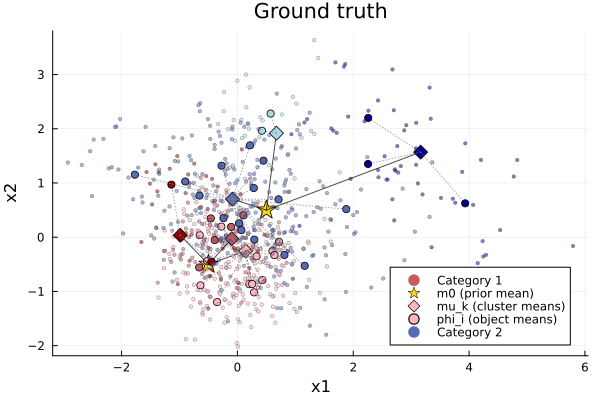

In [4]:
hyper1 = ObjectAwareHDPHyperparams(
    m0 = m0_1, 
    k_clu = K_CLU,
    k_obj = K_OBJ,
    k_per = K_PER,
    sigma2 = sigma2_1,
    alpha = ALPHA
)
category1 = sample_category(j=1, Ii=Ii, O=O, d=D, hyper=hyper1, rng=MersenneTwister(53));
@save "data/ground_truth_category1.jld2" hyper1 category1
CSV.write("data/category1.csv", category_df(category1));

hyper2 = ObjectAwareHDPHyperparams(
    m0 = m0_2, 
    k_clu = K_CLU,
    k_obj = K_OBJ,
    k_per = K_PER,
    sigma2 = sigma2_2,
    alpha = ALPHA
)
category2 = sample_category(j=2, Ii=Ii, O=O, d=D, hyper=hyper2, rng=MersenneTwister(56)); # 43, 53, 54, 56
@save "data/ground_truth_category2.jld2" hyper2 category2
CSV.write("data/category2.csv", category_df(category2));

plot_categories([category1, category2], [hyper1, hyper2], plot_circles=false, title="Ground truth")

# Train/test split & sampling percepts

## Pseudocode for constructing training/test set

Within each category, 

10 objects & 50 percepts in training
- Skewed: [18, 8, 6, 5, 4, 3, 2, 2, 1, 1]
- Uniform: 5 percepts/objects 

10 objects & 50 percepts in test
- 5 percepts/objects

Use sample_category() to sample 20 objects, each with 18 percepts / category
Construct the sets s.t.
- Each object can be the most dominant one
- Each object can appear in both training and test
- If an object is not the most dominant one in training / is part of test set, randomly sample the number of percepts needed

Get permutation of object ids 1-20. The first 10 becomes training (with frequency in this order) and the last 10 becomes test.

## Sampling the train/test splits for model training and testing

In [5]:
cat1_splits = Vector{CategoryTrainTest}(undef, 0)
cat2_splits = Vector{CategoryTrainTest}(undef, 0)

for seed in 1:60
    rng = MersenneTwister(seed)
    push!(cat1_splits, train_test_split_sample_percepts(category1; rng=rng))
    push!(cat2_splits, train_test_split_sample_percepts(category2; rng=rng))
end

@save "data/train_test_splits.jld2" cat1_splits cat2_splits

## Visualize sample train/test splits and percept samples

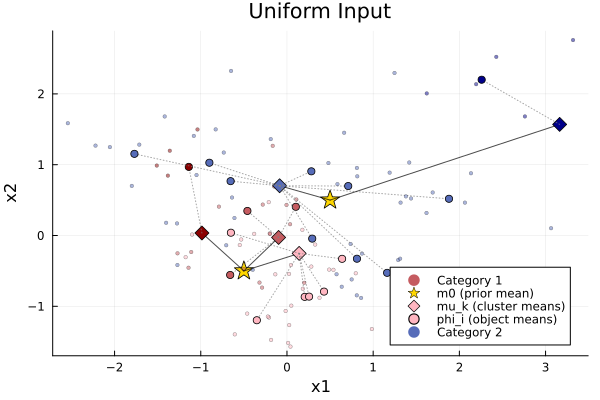

In [6]:
category1_train_uniform = CategorySample(category1.j, category1.sigma2, category1.mus, cat1_splits[59].train_objects_uniform);
CSV.write("data/sample_cat1_train_uniform.csv", category_df(category1_train_uniform));
category2_train_uniform = CategorySample(category2.j, category2.sigma2, category2.mus, cat2_splits[59].train_objects_uniform);
CSV.write("data/sample_cat2_train_uniform.csv", category_df(category2_train_uniform));
plot_categories([category1_train_uniform, category2_train_uniform], [hyper1, hyper2], 
                title="Uniform Input", plot_circles=false)

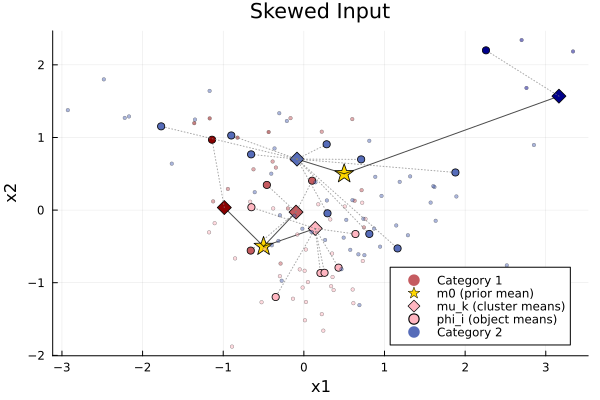

In [7]:
category1_train_skewed = CategorySample(category1.j, category1.sigma2, category1.mus, cat1_splits[59].train_objects_skewed);
CSV.write("data/sample_cat1_train_skewed.csv", category_df(category1_train_skewed));
category2_train_skewed = CategorySample(category2.j, category2.sigma2, category2.mus, cat2_splits[59].train_objects_skewed);
CSV.write("data/sample_cat2_train_skewed.csv", category_df(category2_train_skewed));
plot_categories([category1_train_skewed, category2_train_skewed], [hyper1, hyper2], 
                title="Skewed Input", plot_circles=false)

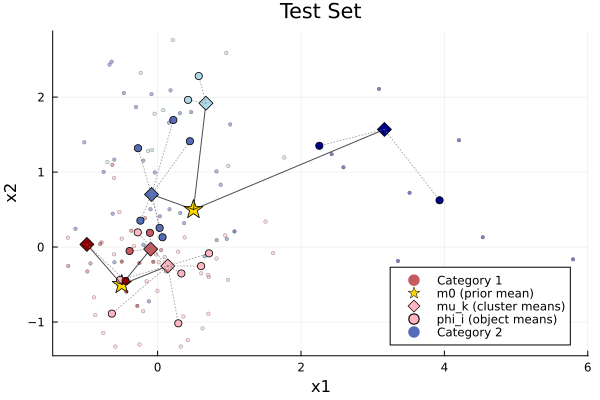

In [8]:
category1_test = CategorySample(category1.j, category1.sigma2, category1.mus, cat1_splits[59].test_objects);
CSV.write("data/sample_cat1_test.csv", category_df(category1_test));
category2_test = CategorySample(category2.j, category2.sigma2, category2.mus, cat2_splits[59].test_objects);
CSV.write("data/sample_cat2_test.csv", category_df(category2_test));
plot_categories([category1_test, category2_test], [hyper1, hyper2], title="Test Set", plot_circles=false)